# Aligning Spectra

This guide shows how to align spectra before they can be averaged.

We use an observation with a mixed observing strategy; position switching and frequency switching.
In this case the on and off source observations also switch the signal in the frequency domain between a signal and a reference state, so there are four switching states: signal with the noise diode, signal without the noise diode, reference with the noise diode and reference without the noise diode.

We will calibrate the signal and reference states independently, using position switching. Then, we'll look at the calibrated spectra as a function of channel and vizualize the shift between the signal and reference states. Finally we will shift the reference state and average it with the signal state.

## Loading Modules
We start by loading the modules we will use for the data reduction. 

For display purposes, we use the static (non-interactive) matplotlib backend in this tutorial. However, you can tell `matplotlib` to use the `ipympl` backend to enable interactive plots. This is only needed if working on jupyter lab or notebook.

In [1]:
# Set interactive plots in jupyter.
#%matplotlib ipympl

# These modules are required for the data reduction.
from dysh.fits.gbtfitsload import GBTFITSLoad
from dysh.log import init_logging

# This module is used for custom plotting.
import matplotlib.pyplot as plt

# These modules are used for file I/O
from dysh.util.files import dysh_data
from pathlib import Path

PJT new in_notebook testing:


## Setup
We start the dysh logging, so we get more information about what is happening.
This is only needed if working on a notebook.
If using the CLI through the ``dysh`` command, then logging is setup for you.

In [2]:
init_logging(2)

# also create a local "output" directory where temporary notebook files can be stored.
output_dir = Path.cwd() / "output"
output_dir.mkdir(exist_ok=True)

## Data Retrieval

Download the example SDFITS data, if necessary.

In [3]:
filename = dysh_data(example="align")

09:22:47.414 I Resolving example=align -> mixed-fs-ps/data/TGBT24B_613_04.raw.vegas.trim.fits
09:22:47.415 I url: http://www.gb.nrao.edu/dysh//example_data/mixed-fs-ps/data/TGBT24B_613_04.raw.vegas.trim.fits


Odd-1, did not find /home/teuben/GBT/dysh_data/example_data/mixed-fs-ps/data/TGBT24B_613_04.raw.vegas.trim.fits
TGBT24B_613_04.raw.vegas.trim.fits already downloaded


## Data Loading

Next, we use `GBTFITSLoad` to load the data, and then its `summary` method to inspect its contents.

In [4]:
sdf = GBTFITSLoad(filename)

In [5]:
sdf.summary()

PJT new in_notebook testing:


SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATION
35,MESSIER32,-200.0,OnOff,1,1.420406,1.420406,1,1,5,1,73.1155,62.2955
36,MESSIER32,-200.0,OnOff,2,1.420406,1.420406,1,1,5,1,72.3087,59.3225


## Data Reduction

### Position Switched Calibration

We calibrate the signal and reference states independently.

In [6]:
# Signal.
ps_sig = sdf.getps(scan=35, sig="T", ifnum=0, plnum=0, fdnum=0).timeaverage()
# Reference.
ps_ref = sdf.getps(scan=35, sig="F", ifnum=0, plnum=0, fdnum=0).timeaverage()

Plot the signal and reference spectra as a function of channel.
Here we use `matplotlib.pyplot` (`plt`) directly, since `dysh` is still not able to show more than one `Spectrum` in a plot.

/home/teuben/GBT/dysh/.venv/lib/python3.12/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


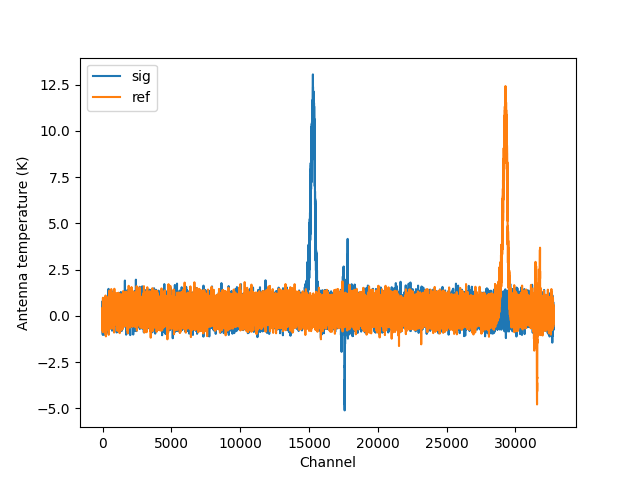

In [7]:
plt.figure()
plt.plot(ps_sig.flux, label="sig")
plt.plot(ps_ref.flux, label="ref")
plt.legend() # Add a legend to display the labels.
# Set the axis labels.
plt.ylabel(f"Antenna temperature ({ps_sig.flux.unit})")
plt.xlabel("Channel");

Compute the rms in a line-free portion of the spectra.

In [8]:
print(f"Noise on the signal state {ps_sig[5000:10000].stats()['rms']:.2f}")
print(f"Noise on the reference state {ps_ref[5000:10000].stats()['rms']:.2f}")

Noise on the signal state 0.41 K
Noise on the reference state 0.40 K


If we were to average the data, then the result would have the spectral line misaligned, since the averaging is done per channel. We can see this if we calibrate the data without separating the signal and reference states. This is less than ideal because the signal gets reduced and the line shows up in two different places even though it is the same line.

In [9]:
ps = sdf.getps(scan=35, fdnum=0, plnum=0, ifnum=0).timeaverage()
ps.plot(xaxis_unit="GHz")

/home/teuben/GBT/dysh/.venv/lib/python3.12/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


### Align Spectra

Instead, we must align the spectra before averaging. In this case we will shift the reference state spectrum to match the signal state spectrum.

/home/teuben/GBT/dysh/.venv/lib/python3.12/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


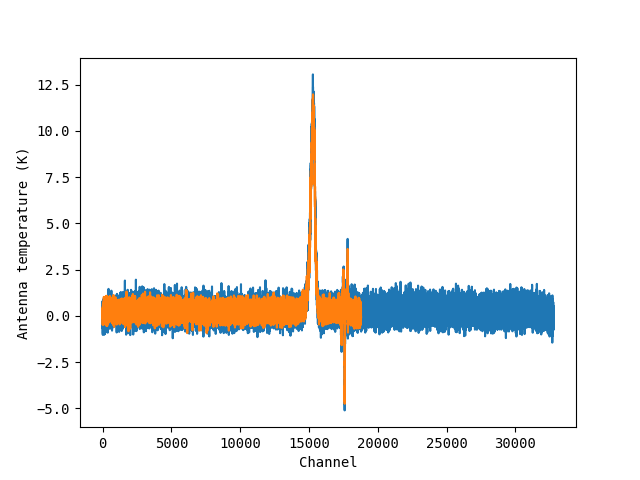

In [10]:
ps_ref_aligned = ps_ref.align_to(ps_sig)

plt.figure()
plt.plot(ps_sig.flux)
plt.plot(ps_ref_aligned.flux)
plt.ylabel(f"Antenna temperature ({ps_sig.flux.unit})")
plt.xlabel("Channel");

Now the spectra are aligned and can be averaged together.

In [11]:
ps_avg = ps_sig.average(ps_ref_aligned)

In [12]:
ps_avg.plot(xaxis_unit="chan")

/home/teuben/GBT/dysh/.venv/lib/python3.12/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


In [13]:
print(f"Noise on the average {ps_avg[5000:10000].stats()['rms']:.2f}")

Noise on the average 0.26 K


The resulting spectrum shows only one peak, at the frequency of the line, and the noise is smaller than in the individual states where the spectra overlapped (channels below ~18000). The noise improvement is better than $\sqrt{2}$ since shifting the reference spectrum for the alignment artificially lowers its noise.

Finally, at the end we compute a fairly meaningless statistic over the whole spectrum, merely as a checksum if the notebook produces the same answer as when it was designed.

## Final Stats

Finally, at the end we compute some statistics over a spectrum, merely as a checksum if the notebook is reproducable.


In [14]:
ps_avg.stats() # rms: 1.03823425 K

{'mean': <Quantity 0.38331295 K>,
 'median': <Quantity 0.2620248 K>,
 'rms': <Quantity 1.03822968 K>,
 'min': <Quantity -4.90857083 K>,
 'max': <Quantity 11.82783923 K>,
 'npt': 32768,
 'nan': np.int64(0)}